In [130]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

# Q Network

In [131]:
class QNetwork(nn.Module):
    def __init__(self, obs_size, n_actions):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(obs_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )

    def forward(self, x):
        return self.model(x)

# Replay Buffer

In [132]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)

# Epsilon-Greedy Policy

In [133]:
def select_action(state, q_network, epsilon, action_space):
    if random.random() < epsilon:
        return random.randint(0, action_space - 1)
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = q_network(state_tensor)
        return q_values.argmax().item()

# Training setup

In [134]:
SEED = 5
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

env = gym.make("CartPole-v1")
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

q_network = QNetwork(obs_space, action_space)
optimizer = optim.Adam(q_network.parameters(), lr=1e-4)
buffer = ReplayBuffer(capacity=100000)

num_episodes = 1000
max_steps = 500
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.998
min_epsilon = 0.1

episode_rewards = []

# Training

In [ ]:
best_reward = 0
for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0

    for _ in range(max_steps):
        action = select_action(state, q_network, epsilon, action_space)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if len(buffer) >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)

            states_tensor = torch.FloatTensor(states)
            actions_tensor = torch.LongTensor(actions).unsqueeze(1)
            rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1)
            next_states_tensor = torch.FloatTensor(next_states)
            dones_tensor = torch.FloatTensor(dones).unsqueeze(1)

            q_values = q_network(states_tensor).gather(1, actions_tensor)

            with torch.no_grad():
                max_next_q = q_network(next_states_tensor).max(1)[0].unsqueeze(1)
                target = rewards_tensor + gamma * max_next_q * (1 - dones_tensor)

            loss = nn.MSELoss()(q_values, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    episode_rewards.append(total_reward)

    if total_reward > best_reward:
        best_reward = total_reward
        torch.save(q_network.state_dict(), "best_dqn_cartpole.pth")
        print(f"Saved new best model at episode {episode+1} with reward {total_reward:.2f}")

    if (episode + 1) % 10 == 0:
        print(f"Episode {episode+1} | Reward: {total_reward:.2f} | Epsilon: {epsilon:.3f}")


Saved new best model at episode 1 with reward 15.00
Saved new best model at episode 2 with reward 55.00
Episode 10 | Reward: 22.00 | Epsilon: 0.980
Saved new best model at episode 19 with reward 60.00
Episode 20 | Reward: 16.00 | Epsilon: 0.961
Episode 30 | Reward: 32.00 | Epsilon: 0.942
Episode 40 | Reward: 21.00 | Epsilon: 0.923
Episode 50 | Reward: 11.00 | Epsilon: 0.905
Episode 60 | Reward: 14.00 | Epsilon: 0.887
Episode 70 | Reward: 12.00 | Epsilon: 0.869
Saved new best model at episode 78 with reward 62.00
Episode 80 | Reward: 29.00 | Epsilon: 0.852
Episode 90 | Reward: 12.00 | Epsilon: 0.835
Episode 100 | Reward: 15.00 | Epsilon: 0.819
Saved new best model at episode 102 with reward 69.00
Episode 110 | Reward: 16.00 | Epsilon: 0.802
Episode 120 | Reward: 12.00 | Epsilon: 0.786
Episode 130 | Reward: 13.00 | Epsilon: 0.771
Episode 140 | Reward: 27.00 | Epsilon: 0.756
Episode 150 | Reward: 13.00 | Epsilon: 0.741
Episode 160 | Reward: 16.00 | Epsilon: 0.726
Episode 170 | Reward: 24.

In [136]:
torch.save(q_network.state_dict(), "dqn_cartpole.pth")
print("\nModel saved to dqn_cartpole.pth")


Model saved to dqn_cartpole.pth


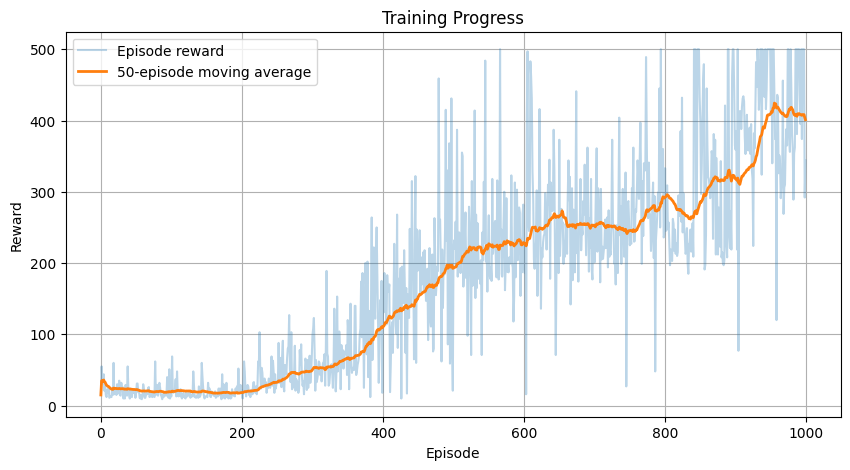

In [ ]:
def plot_rewards(rewards, window=50):
    if len(rewards) < window:
        print("Not enough episodes to plot yet.")
        return
    moving_avg = [np.mean(rewards[max(0, i - window):i + 1]) for i in range(len(rewards))]

    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Episode reward", alpha=0.3)
    plt.plot(moving_avg, label=f"{window}-episode moving average", linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training Progress")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rewards(episode_rewards)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

def plot_rewards(rewards, window=50, save_csv=True, filename="episode_rewards.csv"):
    if len(rewards) < window:
        print("Not enough episodes to plot yet.")
        return

    moving_avg = [np.mean(rewards[max(0, i - window):i + 1]) for i in range(len(rewards))]

    if save_csv:
        df = pd.DataFrame({
            "Episode": np.arange(len(rewards)),
            "Reward": rewards,
            f"MovingAvg_{window}": moving_avg
        })
        df.to_csv(filename, index=False)
        print(f"[Saved] Rewards and moving average written to '{filename}'")

    base_color = '#1f78b4' 
    avg_color = "#ff6d29" 

    plt.figure(figsize=(14, 8))
    plt.plot(rewards, color=base_color, alpha=0.6, linewidth=1.5)
    plt.plot(moving_avg, color=avg_color, linewidth=3)

    plt.xlabel("Episode", fontsize=24)
    plt.ylabel("Reward", fontsize=24)
    plt.title("Training Progress", fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.grid(True, linestyle='--', alpha=0.6)

    legend_elements = [
        Line2D([0], [0], color=base_color, marker='s', markersize=10, label='Episode Reward', linewidth=2),
        Line2D([0], [0], color=avg_color, marker='s', markersize=10, label=f'{window}-Episode Moving Average', linewidth=3)
    ]

    plt.legend(
        handles=legend_elements,
        fontsize=24,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        edgecolor='black'
    )

    plt.tight_layout()
    plt.show()

[Saved] Rewards and moving average written to 'episode_rewards.csv'


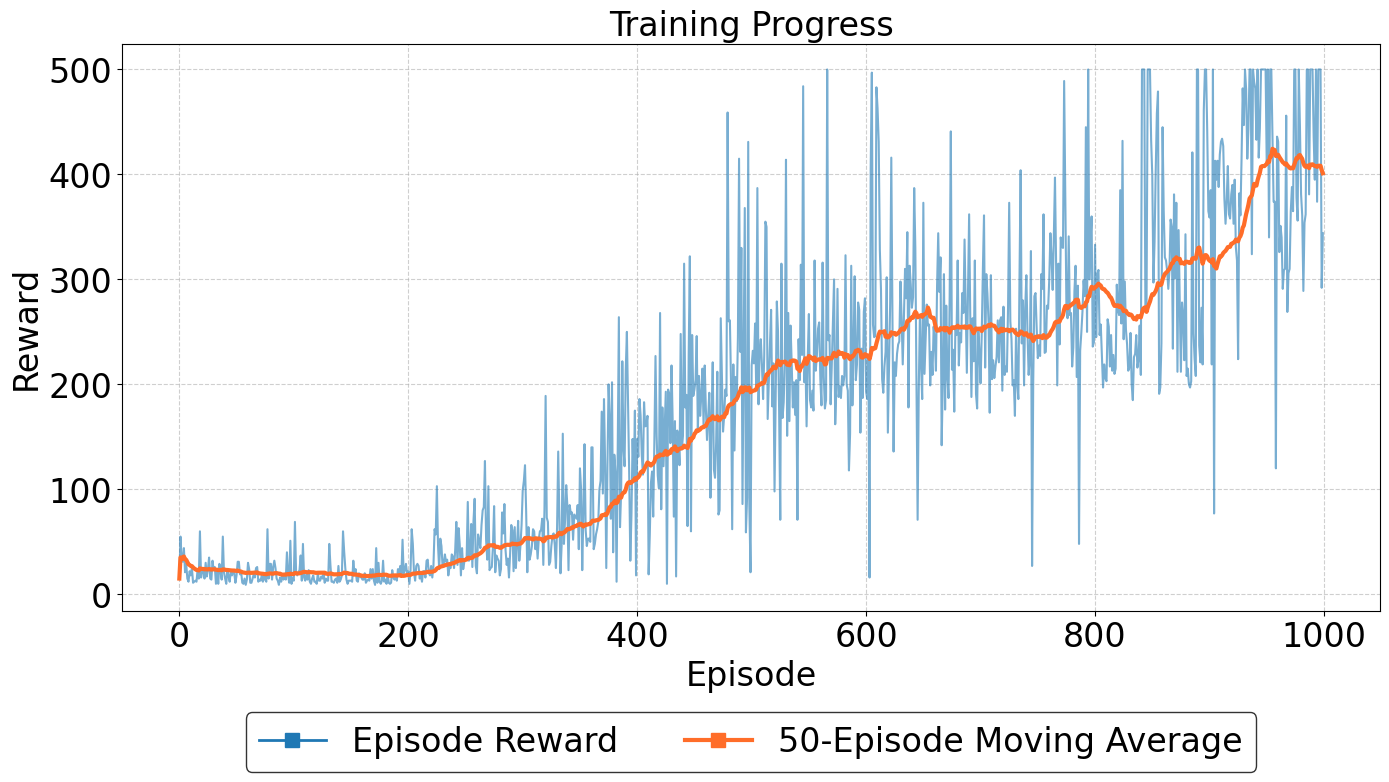

In [142]:
plot_rewards(episode_rewards)

In [140]:
test_env = gym.make("CartPole-v1", render_mode="human")
state, _ = test_env.reset()
done = False
total_reward = 0

while not done:
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        q_values = q_network(state_tensor)
    action = q_values.argmax().item()
    next_state, reward, terminated, truncated, _ = test_env.step(action)
    state = next_state
    total_reward += reward
    done = terminated or truncated

print(f"\nTest episode finished with total reward: {total_reward}")
test_env.close()


Test episode finished with total reward: 500.0
